In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [56]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [57]:
from typing import Annotated, TypedDict

# 一个专门为 AI Agent 优化的搜索引擎 API。
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import os

# 存储在内存中的检查点，程序结束后数据丢失；之前使用的 `sqlite3.connect("checkpoints.db")保存在`db`文件中`，程序结束后数据保留。
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(api_key=os.getenv("TAVILY_API_KEY"))
tools = [tool]
llm = ChatOpenAI(
    model="deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
    temperature=0
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## `tools_condition`

`tools_condition`是 `Langgraph` 提供的便捷函数，用于决定是否需要调用工具。如果发现 `messages` 中最后一个元素中包含工具调用信息，就返回 `tools`，否则返回`__end__`结束 `Langgraph`。

In [58]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

## 人工介入 (Human-in-the-Loop)

`interrupt_before=["tools"]` 的作用是，在执行 `tools` 节点之前，暂停 Graph 运行，等待人工确认。

如果没有这个参数，Graph 会自动执行 `tools` 节点，而不会等待人工确认。有了它后，就会等待人工确认：

```Text
用户输入 → chatbot → ⏸️ 暂停！等待人工确认 → tools → chatbot → 输出结果
                       ↑
                    Graph 在这里停住
                    人可以检查、修改、或取消
```

后面，就可以通过状态快照来获取当前 Graph 的运行状态，并人工决定是否可以继续。

In [59]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

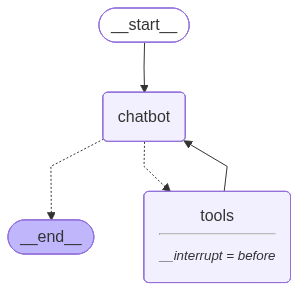

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [63]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Hello, I am Edith!")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am Edith!', additional_kwargs={}, response_metadata={}, id='e01e73d8-c082-48f1-b9b2-f74ed23a7004'),
  AIMessage(content="Hello Edith! It's nice to meet you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 342, 'total_tokens': 359, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 342}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5a03f2e3-7b85-433f-b271-22a19be1892b', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b0104-6a11-7633-8da1-b64c467410e0-0', usage_metadata={'input_tokens': 342, 'output_tokens': 17, 'total_tokens': 359, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]}

In [64]:
from langchain_core.messages import HumanMessage

config = {"configurable":{"thread_id": "100"}}
input_message = HumanMessage(content="Did I introduce myself?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Did I introduce myself?', additional_kwargs={}, response_metadata={}, id='8bdb7e72-6eaa-41e3-b5e7-e7eb6fe555f0'),
  AIMessage(content="I don't have access to our conversation history, so I can't see whether you introduced yourself earlier in this chat. \n\nTo help me understand our conversation context better, could you please tell me who you are and what you'd like to discuss? This will help me provide you with more relevant and personalized assistance.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 341, 'total_tokens': 404, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 21}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '25087670-edf3-446a-bc3c-636af37b0523', 'finish_reason': 'stop', 'l

In [65]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="Did I introduce myself?")
graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am Edith!', additional_kwargs={}, response_metadata={}, id='e01e73d8-c082-48f1-b9b2-f74ed23a7004'),
  AIMessage(content="Hello Edith! It's nice to meet you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 342, 'total_tokens': 359, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 342}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5a03f2e3-7b85-433f-b271-22a19be1892b', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b0104-6a11-7633-8da1-b64c467410e0-0', usage_metadata={'input_tokens': 342, 'output_tokens': 17, 'total_tokens': 359, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
  HumanMessage(content='Did I introduce myself?',

In [67]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="How's weather like in Los Angeles?")
graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am Edith!', additional_kwargs={}, response_metadata={}, id='e01e73d8-c082-48f1-b9b2-f74ed23a7004'),
  AIMessage(content="Hello Edith! It's nice to meet you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 342, 'total_tokens': 359, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 342}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5a03f2e3-7b85-433f-b271-22a19be1892b', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b0104-6a11-7633-8da1-b64c467410e0-0', usage_metadata={'input_tokens': 342, 'output_tokens': 17, 'total_tokens': 359, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
  HumanMessage(content='Did I introduce myself?',

## `graph.get_state(config)`

获取指定线程的当前状态快照，返回一个 StateSnapshot 对象，包含：\

* 当前的 `messages`(对话历史)
* 下一步要执行的节点
* 其他元数据

## `snapshot.next`

查看下一行应该执行哪个节点，返回值是一个元组，例如：

* `('tools', ...)` - 下一步要执行 tools 节点
* `('chatbot', ...)` - 下一步要执行 `chatbot` 节点
* `()` - 空元组，表示流程已结束

## 使用场景

### 场景一：检查 Graph 是否在运行
```Python
snapshot = graph.get_state(config)
if snapshot.next:
    print(f"还没结束，下一步是: {snapshot.next}")
else:
    print("流程已结束")
```

### 场景二：人工介入（Human in the loop）

```Python
snapshot = graph.get_state(config)
print(snapshot.next)  # 比如输出 ('tools',) 表示等待执行工具

# 人工确认后，继续执行
graph.invoke(None, config)  # 传 None 表示"继续执行"
```

In [71]:
# 获取指定线程的当前状态快照，返回一个 StateSnapshot 对象，包含：
snapshot = graph.get_state(config)
# print(snapshot)
snapshot.next

StateSnapshot(values={'messages': [HumanMessage(content='Hello, I am Edith!', additional_kwargs={}, response_metadata={}, id='e01e73d8-c082-48f1-b9b2-f74ed23a7004'), AIMessage(content="Hello Edith! It's nice to meet you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 342, 'total_tokens': 359, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 342}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5a03f2e3-7b85-433f-b271-22a19be1892b', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b0104-6a11-7633-8da1-b64c467410e0-0', usage_metadata={'input_tokens': 342, 'output_tokens': 17, 'total_tokens': 359, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}), HumanMessage(content='Did I in

('tools',)

In [70]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='Hello, I am Edith!', additional_kwargs={}, response_metadata={}, id='e01e73d8-c082-48f1-b9b2-f74ed23a7004'),
  AIMessage(content="Hello Edith! It's nice to meet you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 342, 'total_tokens': 359, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 342}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5a03f2e3-7b85-433f-b271-22a19be1892b', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b0104-6a11-7633-8da1-b64c467410e0-0', usage_metadata={'input_tokens': 342, 'output_tokens': 17, 'total_tokens': 359, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
  HumanMessage(content='Did I introduce myself?',

In [72]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="How is the weather in Los Angeles?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Los Angeles?', additional_kwargs={}, response_metadata={}, id='8370f22f-9052-4c86-b6f7-b442d8acaf72'),
  AIMessage(content="I'll search for current weather information in Los Angeles.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 344, 'total_tokens': 405, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 24}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '01a4e9df-1863-41d7-99c5-1fb93ac8a1aa', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b01a3-8428-7bb3-8b01-8832abd0256b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather Los Angeles today'}, 'id': 'call_00_djRCXv1BPcSMvxVE3I92CDVR', 'type': 'tool_call'}], usage

In [83]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print() # pretty_print() 是 Langchain 提供的格式化输出的方法，提高了易读性

================================== Ai Message ==================================

I'll search for current weather information in Los Angeles.
Tool Calls:
  tavily_search_results_json (call_00_djRCXv1BPcSMvxVE3I92CDVR)
 Call ID: call_00_djRCXv1BPcSMvxVE3I92CDVR
  Args:
    query: current weather Los Angeles today


# Agent 执行流程

用户提问 → AI 决定调用工具 → 工具执行 → 返回 ToolMessage → AI 读取结果 → AI 生成最终回复

In [87]:
# Mock up ToolMessage，以及 AI 读取后返回的最终回复结果

from langchain_core.messages import AIMessage, ToolMessage

tool_output = '{"temp": 5, "unit": "C"}'
final_response = "It is only 5℃ warm today!"

new_messages = [
    ToolMessage(content=tool_output, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=final_response),
]

In [88]:
new_messages[-1].pretty_print()
graph.update_state(config, {"messages": new_messages})

================================== Ai Message ==================================

It is only 5℃ warm today!


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d4c41-72da-646d-8002-ddc4d89aafcf'}}

In [89]:
print(graph.get_state(config).values["messages"][-2:])

[ToolMessage(content='{"temp": 5, "unit": "C"}', id='23045e2c-950a-48a0-a93b-209622d937a1', tool_call_id='call_00_djRCXv1BPcSMvxVE3I92CDVR'), AIMessage(content='It is only 5℃ warm today!', additional_kwargs={}, response_metadata={}, id='4b141f80-e81d-4a7e-a05d-da46b66fde2c')]


In [90]:
config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="How warm was it again?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Los Angeles?', additional_kwargs={}, response_metadata={}, id='8370f22f-9052-4c86-b6f7-b442d8acaf72'),
  AIMessage(content="I'll search for current weather information in Los Angeles.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 344, 'total_tokens': 405, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 24}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '01a4e9df-1863-41d7-99c5-1fb93ac8a1aa', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b01a3-8428-7bb3-8b01-8832abd0256b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather Los Angeles today'}, 'id': 'call_00_djRCXv1BPcSMvxVE3I92CDVR', 'type': 'tool_call'}], usage